In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [66]:
path = 'MovieSummaries/'

character=pd.read_csv(path+'character.metadata.tsv',sep='\t',header=None, names=['wiki_movie_ID','Freebase_movie_ID','release_date','character_name','actor_birth','actor_gender','actor_height','actor_ethnicity','actor_name','actor_age','character_actor_map_ID','Freebase_character_ID','Freebase_actor_ID'])
cmu_movies = pd.read_csv(path+'movie.metadata.tsv',sep='\t',header=None,names=['wiki_movie_ID','Freebase_movie_ID','movie_name','date','revenue','runtime','languages','countries','genres'])
name = pd.read_csv(path+'name.clusters.txt',sep='\t',header=None,names=['name','character_actor_map_ID'])
plot_summary = pd.read_csv(path+'plot_summaries.txt',sep='\t',header=None,names=['wiki_movie_ID','summary'])
tv_tropes = pd.read_csv(path+'tvtropes.clusters.txt',sep='\t',header=None,names=['name','character_actor_map'])
imdb_movies = pd.read_csv(path+'imdb_title.tsv',sep='\t')
ratings = pd.read_csv(path+'rating.tsv',sep='\t')


/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [67]:
display(character.head())
display(cmu_movies.head())
display(name.head())
display(plot_summary.head())
display(tv_tropes.head())
display(imdb_movies.head())
display(ratings.head())

,wiki_movie_ID,Freebase_movie_ID,release_date,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


,wiki_movie_ID,Freebase_movie_ID,movie_name,date,revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


,name,character_actor_map_ID
0,Stuart Little,/m/0k3w9c
1,Stuart Little,/m/0k3wcx
2,Stuart Little,/m/0k3wbn
3,John Doe,/m/0jyg35
4,John Doe,/m/0k2_zn


,wiki_movie_ID,summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


,name,character_actor_map
0,absent_minded_professor,"{""char"": ""Professor Philip Brainard"", ""movie"":..."
1,absent_minded_professor,"{""char"": ""Professor Keenbean"", ""movie"": ""Richi..."
2,absent_minded_professor,"{""char"": ""Dr. Reinhardt Lane"", ""movie"": ""The S..."
3,absent_minded_professor,"{""char"": ""Dr. Harold Medford"", ""movie"": ""Them!..."
4,absent_minded_professor,"{""char"": ""Daniel Jackson"", ""movie"": ""Stargate""..."


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


,tconst,averageRating,numVotes
0,tt0000001,5.7,1922
1,tt0000002,5.8,259
2,tt0000003,6.5,1734
3,tt0000004,5.6,174
4,tt0000005,6.2,2545


In [69]:
#   UNIQUE MOVIE NAMES
print(len(cmu_movies.movie_name.unique()))
print(len(imdb_movies.originalTitle.unique()))

75478
4305335


In [70]:
cmu_movies['month_day'] = cmu_movies['date'].apply(lambda x: x[5:] if len(str(x))>3 else np.nan)
cmu_movies['year'] = cmu_movies['date'].apply(lambda x: x[0:4] if len(str(x))>3 else x)
cmu_movies=cmu_movies.drop('date', axis = 1)

### Merging CMU and IMDB datasets

In [71]:
movies = cmu_movies.merge(imdb_movies,left_on=['movie_name', 'year'],right_on=['primaryTitle', 'startYear'], how="inner")
print(movies.shape)


(61081, 19)


In [72]:
#adding the ratings feature

movies_with_ratings= movies.merge(ratings, left_on='tconst', right_on='tconst', how='inner')
print(movies_with_ratings.shape)

(50834, 21)


In [73]:
movies_with_ratings.head()

,wiki_movie_ID,Freebase_movie_ID,movie_name,revenue,runtime,languages,countries,genres_x,month_day,year,...,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres_y,averageRating,numVotes
0,975900,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",08-24,2001,...,movie,Ghosts of Mars,Ghosts of Mars,0,2001,\N,98,"Action,Horror,Sci-Fi",4.9,55237
1,975900,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",08-24,2001,...,tvEpisode,Ghosts of Mars,Ghosts of Mars,0,2001,\N,\N,"Documentary,Short",7.9,19
2,28463795,/m/0crgdbh,Brun bitter,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",,1988,...,movie,Brun bitter,Brun bitter,0,1988,\N,83,"Crime,Drama",5.7,40
3,261236,/m/01mrr1,A Woman in Flames,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",,1983,...,movie,A Woman in Flames,Die flambierte Frau,0,1983,\N,106,Drama,6.0,590
4,13696889,/m/03cfc81,The Gangsters,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",05-29,1913,...,short,The Gangsters,The Gangsters,0,1913,\N,35,"Comedy,Short",6.8,16


In [74]:
#Dropping useless or redundant features
movies_with_ratings = movies_with_ratings.drop('genres_y', axis = 1)
movies_with_ratings = movies_with_ratings.rename(columns = {'genres_x':'genres'})
movies_with_ratings = movies_with_ratings.drop('Freebase_movie_ID', axis = 1)
#movies_with_ratings = movies_with_ratings.drop('tconst', axis = 1)
movies_with_ratings = movies_with_ratings.drop('primaryTitle', axis = 1)
movies_with_ratings = movies_with_ratings.drop('originalTitle', axis = 1)
movies_with_ratings = movies_with_ratings.drop('runtimeMinutes', axis = 1)
movies_with_ratings = movies_with_ratings.drop('startYear', axis = 1)

In [75]:
movies_with_ratings['languages'] = movies_with_ratings['languages'].apply(lambda x: list(json.loads(x).values()))
movies_with_ratings['countries'] = movies_with_ratings['countries'].apply(lambda x: list(json.loads(x).values()))
movies_with_ratings['genres'] = movies_with_ratings['genres'].apply(lambda x: list(json.loads(x).values()))

In [76]:
print('The percentage of null values for the feature endYear is', np.array(movies_with_ratings.endYear == '\\N').sum()/movies_with_ratings.shape[0])

The percentage of null values for the feature endYear is 0.993390250619664


In [77]:
movies_with_ratings = movies_with_ratings.drop('endYear', axis = 1)

- #### Dropping movies with less than 20 vote numbers for a credible ratings analysis

In [78]:
movies_with_ratings = movies_with_ratings[movies_with_ratings['numVotes']>= 20]

Drop rows with 0 runtime:

In [79]:
#movies_with_ratings = movies_with_ratings.drop(np.where(movies_with_ratings['runtime'] == 0)[0], axis = 0)

In [80]:
movies_with_ratings.head()

,wiki_movie_ID,movie_name,revenue,runtime,languages,countries,genres,month_day,year,tconst,titleType,isAdult,averageRating,numVotes
0,975900,Ghosts of Mars,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",08-24,2001,tt0228333,movie,0,4.9,55237
2,28463795,Brun bitter,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",,1988,tt0094806,movie,0,5.7,40
3,261236,A Woman in Flames,NaN,106.0,[German Language],[Germany],[Drama],,1983,tt0083949,movie,0,6.0,590
5,10408933,Alexander's Ragtime Band,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",08-16,1938,tt0029852,movie,0,6.9,2159
6,175026,Sarah and Son,NaN,86.0,[English Language],[United States of America],"[Drama, Black-and-white]",,1930,tt0021335,movie,0,5.4,272


We will now check for non unicity of the movies in the dataset:

In [81]:
### added titletype
duplicates = movies_with_ratings.loc[movies_with_ratings.duplicated(subset=['wiki_movie_ID'], keep = False)]

In [82]:
duplicates.head()

,wiki_movie_ID,movie_name,revenue,runtime,languages,countries,genres,month_day,year,tconst,titleType,isAdult,averageRating,numVotes
76,7707787,Carmen,NaN,119.0,"[French Language, Spanish Language]",[Spain],"[Romantic drama, Romance Film, Drama, World ci...",10-03,2003,tt0352230,movie,0,6.1,2176
77,7707787,Carmen,NaN,119.0,"[French Language, Spanish Language]",[Spain],"[Romantic drama, Romance Film, Drama, World ci...",10-03,2003,tt0372361,movie,0,6.2,162
85,7460227,The Bridge,NaN,69.0,[English Language],[United States of America],[Drama],09-01,2006,tt0799954,movie,0,7.2,11717
86,4953051,The Bridge,NaN,94.0,[English Language],"[United States of America, United Kingdom]",[Documentary],,2006,tt0799954,movie,0,7.2,11717
87,7460227,The Bridge,NaN,69.0,[English Language],[United States of America],[Drama],09-01,2006,tt0907842,movie,0,7.6,171


In [83]:
for i in range(len(duplicates.wiki_movie_ID.unique())):# for loop per each duplicate
    orig = movies_with_ratings[movies_with_ratings.wiki_movie_ID == duplicates.wiki_movie_ID.unique()[i]]# find them in the original dataset
    movies_with_ratings = movies_with_ratings.drop(list(orig[orig.numVotes !=orig.numVotes.max()].index))# drop the values that are not max


In [84]:
#there are movies with the same Id but different titleType and rating
movies_with_ratings.loc[movies_with_ratings.duplicated(subset=['wiki_movie_ID'], keep = False)].head()

,wiki_movie_ID,movie_name,revenue,runtime,languages,countries,genres,month_day,year,tconst,titleType,isAdult,averageRating,numVotes
6471,8379071,The Bet,NaN,85.0,"[Italian Language, English Language, Spanish L...",[Italy],"[Biographical film, Comedy]",12-11,2007,tt0461012,movie,0,8.1,49
6472,8379071,The Bet,NaN,85.0,"[Italian Language, English Language, Spanish L...",[Italy],"[Biographical film, Comedy]",12-11,2007,tt1032009,short,0,7.6,49


### Let's standardize the numVotes and the averageRating

In [85]:
COLUMNS = ['revenue', 'runtime', 'numVotes', 'averageRating']
for i in range(len(COLUMNS)):
    movies_with_ratings[COLUMNS[i]] = (movies_with_ratings[COLUMNS[i]] - movies_with_ratings[COLUMNS[i]].min())/(movies_with_ratings[COLUMNS[i]].max()-movies_with_ratings[COLUMNS[i]].min())


In [87]:
def groupby_many(data, groups):
    """
    Groups a Series or DataFrame object where each row can belong to many groups.

    Parameters
    ----------
    data : Series or DataFrame
        The data to group
    groups : iterable of iterables
        For each row in data, the groups that row belongs to.
        A row can belong to zero, one, or multiple groups.

    Returns
    -------
    A GroupBy object    
    """ 
    pairs = [(i, g) for (i, gg) in enumerate(groups) for g in gg]
    row, group = zip(*pairs)
    return data.iloc[list(row)].groupby(list(group))

In [89]:
#plot of top 20 countries for ratings
languages_20 = groupby_many(movies_with_ratings, movies_with_ratings['languages'])[['numVotes']].mean().sort_values('numVotes', ascending=False)[0:20]
languages_20.head()





,numVotes
Old English language,0.458539
Hmong language,0.291127
Chewa language,0.256192
Sicilian Language,0.231468
Krio Language,0.206495


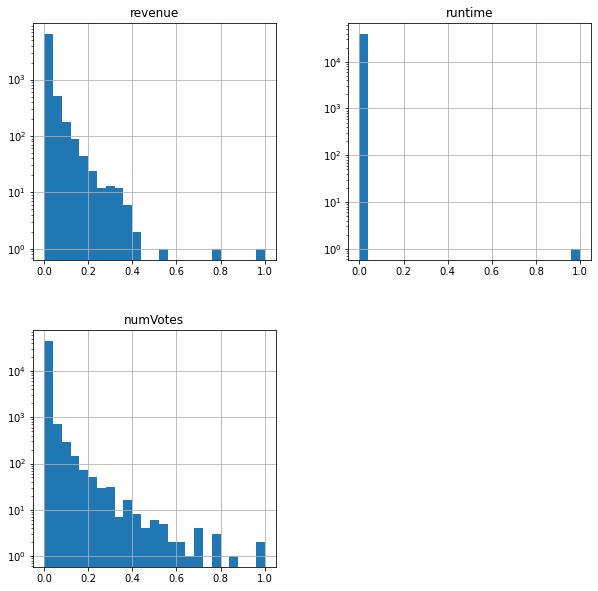

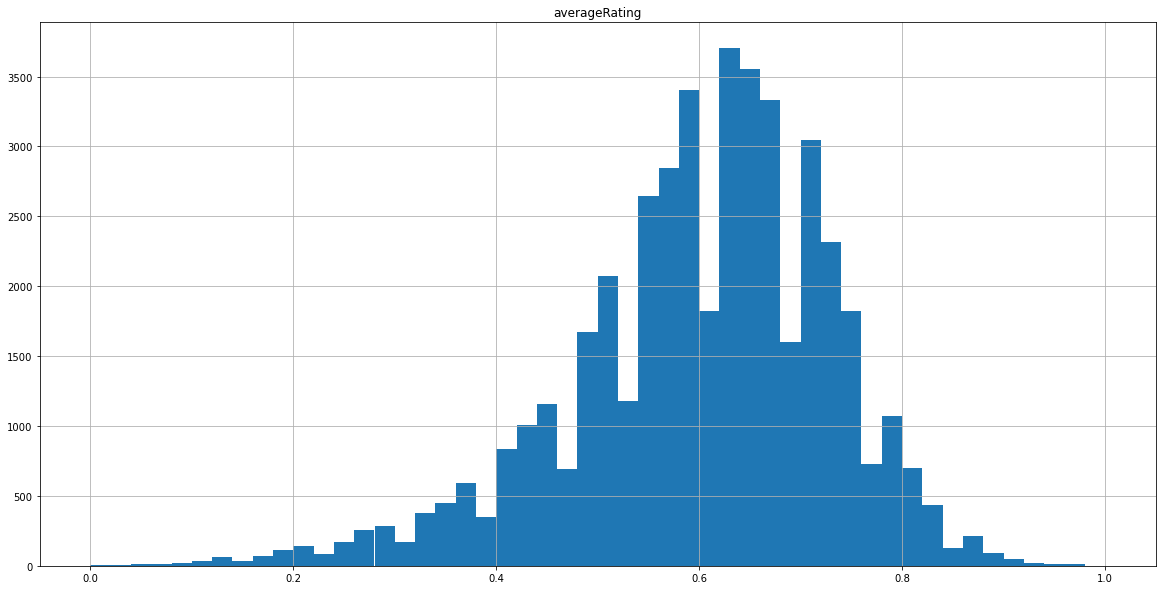

In [90]:
#distributions

movies_with_ratings[['revenue', 'runtime', 'numVotes']].hist(bins=25, figsize=(10,10), log = True, label = ['log_revenue', 'log_runtime','log_numvotes'])
movies_with_ratings[['year', 'averageRating']].hist(bins=50, figsize=(20,10), log = False)
plt.show()

Text(0.5, 1.0, 'plot of 10 best rated languages')

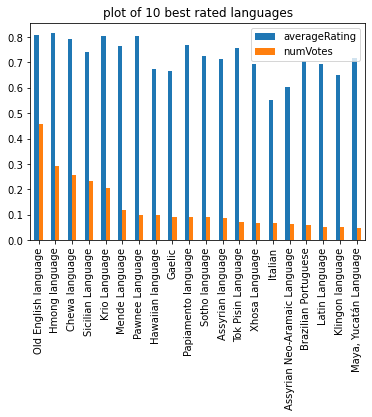

In [91]:
groupby_many(movies_with_ratings, movies_with_ratings['languages'])[['averageRating', 'numVotes']].mean().sort_values('numVotes', ascending=False)[0:20].plot(kind='bar')
plt.title('plot of 10 best rated languages')


Text(0.5, 1.0, 'plot of 10 best rated countries')

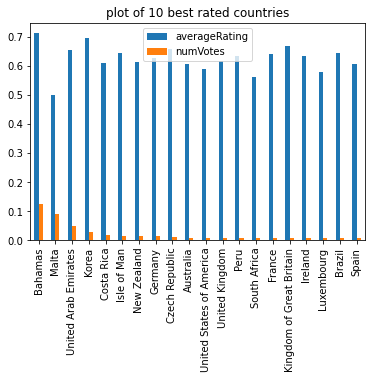

In [92]:
groupby_many(movies_with_ratings, movies_with_ratings['countries'])[['averageRating', 'numVotes']].mean().sort_values('numVotes', ascending=False)[0:20].plot(kind='bar')
plt.title('plot of 10 best rated countries')

Text(0.5, 1.0, 'plot of 10 best rated genres')

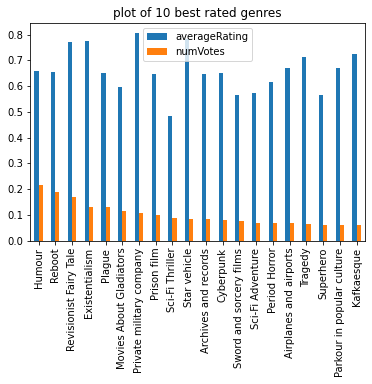

In [94]:
result = groupby_many(movies_with_ratings, movies_with_ratings['genres'])
(result[['averageRating', 'numVotes']].mean().sort_values('numVotes', ascending=False))[0:20].plot(kind='bar')

plt.title('plot of 10 best rated genres')
